> > **题目**：基于 ResNet50 的水果分类
> > **背景**：使用基于卷积的深度神经网络 ResNet50 对 30 种水果进行分类
> > **任务**
> > 
> > 1. 划分训练集和验证集
> > 2. 按照 MMPreTrain CustomDataset 格式组织训练集和验证集
> > 3. 使用 MMPreTrain 算法库，编写配置文件，正确加载预训练模型
> > 4. 在水果数据集上进行微调训练
> > 5. 使用 MMPreTrain 的 ImageClassificationInferencer 接口，对网络水果图像，或自己拍摄的水果图像，使用训练好的模型进行分类
> > 
> > 需提交的验证集评估指标（不能低于 60%）
> > 
> > * ResNet-50
> > 
> > ![](https://user-images.githubusercontent.com/94358981/243633153-f76b4aa5-e4d6-4c02-bff9-09d974268bfa.png)
> > **作业数据集下载**： 链接：https://pan.baidu.com/s/1YgoU1M_v7ridtXB9xxbA1Q 提取码：52m9
> > **课程中猫狗数据集下载地址**： https://download.openmmlab.com/mmclassification/dataset/cats_dogs_dataset.tar
> > **提交方式** 请将作业内容上传到你自己的github仓库，并把对应的链接回复在评论区



# 环境配置

In [1]:
!git clone https://github.com/open-mmlab/mmpretrain.git
%cd mmpretrain
!pip install -U openmim && mim install -e .

Cloning into 'mmpretrain'...
remote: Enumerating objects: 16733, done.
remote: Counting objects: 100% (1564/1564), done.
remote: Compressing objects: 100% (610/610), done.
remote: Total 16733 (delta 986), reused 1394 (delta 935), pack-reused 15169
Receiving objects: 100% (16733/16733), 13.27 MiB | 25.02 MiB/s, done.
Resolving deltas: 100% (11617/11617), done.
/content/mmpretrain
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 1.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
Obtaining file:///content/mmpretrain
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━

# 获取完整配置文件
原理：即使在训练时因为数据集不存在而无法成功运行也会生成完整的配置文件

In [2]:
!python /content/mmpretrain/tools/train.py /content/mmpretrain/configs/convmixer/convmixer-768-32_10xb64_in1k.py

06/07 06:42:40 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 1816828518
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50

# 数据集下载+解压

In [3]:
!gdown https://drive.google.com/uc?id=16AvoLcKzCfvsKFRVQ-RGVnsTRWzAe7ze 

Downloading...
From: https://drive.google.com/uc?id=16AvoLcKzCfvsKFRVQ-RGVnsTRWzAe7ze
To: /content/mmpretrain/fruit30_train.tar
100% 187M/187M [00:04<00:00, 44.6MB/s]


In [4]:
import tarfile

tar_path = "/content/mmpretrain/fruit30_train.tar"  # Path to your tar file
destination_path = "/content/mmpretrain/data/fruits"  # Path to the destination folder

with tarfile.open(tar_path) as tar:
    tar.extractall(path=destination_path)


# 类别数确认

In [5]:
import os

folder_path = "/content/mmpretrain/data/fruits"  # replace with your folder path
items = os.listdir(folder_path)

folder_count = sum([1 for item in items if os.path.isdir(os.path.join(folder_path, item))])

print("Number of folders:", folder_count)


Number of folders: 30


# 划分数据集

In [6]:
import os
import shutil
import random

# 定义路径
data_path = "/content/mmpretrain/data/fruits"  # 源数据路径
train_path = "./data/train"  # 训练集路径
valid_path = "./data/valid"  # 验证集路径
test_path = "./data/test"  # 测试集路径

# 创建train, valid, test文件夹
os.makedirs(train_path, exist_ok=True)
os.makedirs(valid_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# 遍历data文件夹下的每个子文件夹
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    if os.path.isdir(folder_path):
        # 创建相应的子文件夹
        os.makedirs(os.path.join(train_path, folder), exist_ok=True)
        os.makedirs(os.path.join(valid_path, folder), exist_ok=True)
        os.makedirs(os.path.join(test_path, folder), exist_ok=True)

        # 获取子文件夹中的文件列表
        files = os.listdir(folder_path)
        # 打乱文件顺序
        random.shuffle(files)

        # 计算训练、验证、测试集的文件数量
        train_count = int(len(files) * 0.7)
        valid_count = int(len(files) * 0.2)
        test_count = len(files) - train_count - valid_count

        # 分别划分训练、验证、测试集
        train_files = files[:train_count]
        valid_files = files[train_count:(train_count+valid_count)]
        test_files = files[(train_count+valid_count):]

        # 移动文件
        for file in train_files:
            shutil.move(os.path.join(folder_path, file), os.path.join(train_path, folder, file))
        for file in valid_files:
            shutil.move(os.path.join(folder_path, file), os.path.join(valid_path, folder, file))
        for file in test_files:
            shutil.move(os.path.join(folder_path, file), os.path.join(test_path, folder, file))


# 修改配置文件

In [ ]:
# https://download.openmmlab.com/mmclassification/v0/convmixer/convmixer-768-32_3rdparty_10xb64_in1k_20220323-bca1f7b8.pth

In [19]:
cfg="""
model = dict(
    type='ImageClassifier',
    backbone=dict(type='ConvMixer', arch='768/32', act_cfg=dict(type='ReLU')),
    neck=dict(type='GlobalAveragePooling'),
    head=dict(
        type='LinearClsHead',
        num_classes=30,
        in_channels=768,
        loss=dict(type='CrossEntropyLoss', loss_weight=1.0)))
dataset_type = 'CustomDataset'
data_preprocessor = dict(
    num_classes=30,
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    to_rgb=True)
bgr_mean = [103.53, 116.28, 123.675]
bgr_std = [57.375, 57.12, 58.395]
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='RandomResizedCrop',
        scale=224,
        backend='pillow',
        interpolation='bicubic'),
    dict(type='RandomFlip', prob=0.5, direction='horizontal'),
    dict(
        type='RandAugment',
        policies='timm_increasing',
        num_policies=2,
        total_level=10,
        magnitude_level=9,
        magnitude_std=0.5,
        hparams=dict(pad_val=[104, 116, 124], interpolation='bicubic')),
    dict(
        type='RandomErasing',
        erase_prob=0.25,
        mode='rand',
        min_area_ratio=0.02,
        max_area_ratio=0.3333333333333333,
        fill_color=[103.53, 116.28, 123.675],
        fill_std=[57.375, 57.12, 58.395]),
    dict(type='PackInputs')
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='ResizeEdge',
        scale=233,
        edge='short',
        backend='pillow',
        interpolation='bicubic'),
    dict(type='CenterCrop', crop_size=224),
    dict(type='PackInputs')
]
train_dataloader = dict(
    pin_memory=True,
    persistent_workers=True,
    collate_fn=dict(type='default_collate'),
    batch_size=32,
    num_workers=5,
    dataset=dict(
        type='CustomDataset',
        data_root='/content/mmpretrain/data/train',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='RandomResizedCrop',
                scale=224,
                backend='pillow',
                interpolation='bicubic'),
            dict(type='RandomFlip', prob=0.5, direction='horizontal'),
            dict(
                type='RandAugment',
                policies='timm_increasing',
                num_policies=2,
                total_level=10,
                magnitude_level=9,
                magnitude_std=0.5,
                hparams=dict(pad_val=[104, 116, 124],
                             interpolation='bicubic')),
            dict(
                type='RandomErasing',
                erase_prob=0.25,
                mode='rand',
                min_area_ratio=0.02,
                max_area_ratio=0.3333333333333333,
                fill_color=[103.53, 116.28, 123.675],
                fill_std=[57.375, 57.12, 58.395]),
            dict(type='PackInputs')
        ]),
    sampler=dict(type='DefaultSampler', shuffle=True))
val_dataloader = dict(
    pin_memory=True,
    persistent_workers=True,
    collate_fn=dict(type='default_collate'),
    batch_size=32,
    num_workers=5,
    dataset=dict(
        type='CustomDataset',
        data_root='/content/mmpretrain/data/valid',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='ResizeEdge',
                scale=233,
                edge='short',
                backend='pillow',
                interpolation='bicubic'),
            dict(type='CenterCrop', crop_size=224),
            dict(type='PackInputs')
        ]),
    sampler=dict(type='DefaultSampler', shuffle=False))
val_evaluator = dict(type='Accuracy', topk=1)
test_dataloader = dict(
    pin_memory=True,
    persistent_workers=True,
    collate_fn=dict(type='default_collate'),
    batch_size=32,
    num_workers=5,
    dataset=dict(
        type='CustomDataset',
        data_root='/content/mmpretrain/data/test',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='ResizeEdge',
                scale=233,
                edge='short',
                backend='pillow',
                interpolation='bicubic'),
            dict(type='CenterCrop', crop_size=224),
            dict(type='PackInputs')
        ]),
    sampler=dict(type='DefaultSampler', shuffle=False))
test_evaluator = dict(type='Accuracy', topk=1)
optim_wrapper = dict(
    optimizer=dict(
        type='AdamW',
        lr=0.01,
        weight_decay=0.05,
        eps=1e-08,
        betas=(0.9, 0.999)),
    paramwise_cfg=dict(
        norm_decay_mult=0.0,
        bias_decay_mult=0.0,
        flat_decay_mult=0.0,
        custom_keys=dict({
            '.absolute_pos_embed': dict(decay_mult=0.0),
            '.relative_position_bias_table': dict(decay_mult=0.0)
        })),
    clip_grad=dict(max_norm=5.0))
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=0.001,
        by_epoch=True,
        end=20,
        convert_to_iter_based=True),
    dict(type='CosineAnnealingLR', eta_min=1e-05, by_epoch=True, begin=20)
]
train_cfg = dict(by_epoch=True, max_epochs=300, val_interval=1)
val_cfg = dict()
test_cfg = dict()
auto_scale_lr = dict(base_batch_size=640)
default_scope = 'mmpretrain'
default_hooks = dict(
    timer=dict(type='IterTimerHook'),
    logger=dict(type='LoggerHook', interval=5),
    param_scheduler=dict(type='ParamSchedulerHook'),
    checkpoint=dict(type='CheckpointHook', interval=1),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    visualization=dict(type='VisualizationHook', enable=False))
env_cfg = dict(
    cudnn_benchmark=False,
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0),
    dist_cfg=dict(backend='nccl'))
vis_backends = [dict(type='LocalVisBackend')]
visualizer = dict(
    type='UniversalVisualizer', vis_backends=[dict(type='LocalVisBackend')])
log_level = 'INFO'
load_from = 'https://download.openmmlab.com/mmclassification/v0/convmixer/convmixer-768-32_3rdparty_10xb64_in1k_20220323-bca1f7b8.pth'
resume = False
randomness = dict(seed=None, deterministic=False)
launcher = 'none'
work_dir = './work_dirs/convmixer-768-32_10xb64_in1k'
"""
with open('/content/mmpretrain/work_dirs/convmixer-768-32_10xb64_in1k/convmixer-768-32_10xb64_in1k.py', 'w') as f: 
    f.write(cfg)


# 开始训练

In [20]:
!python /content/mmpretrain/tools/train.py /content/mmpretrain/work_dirs/convmixer-768-32_10xb64_in1k/convmixer-768-32_10xb64_in1k.py

06/07 06:54:36 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 1116239824
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50

# 推理测试

In [21]:
!python /content/mmpretrain/tools/test.py /content/mmpretrain/work_dirs/convmixer-768-32_10xb64_in1k/convmixer-768-32_10xb64_in1k.py /content/mmpretrain/work_dirs/convmixer-768-32_10xb64_in1k/epoch_3.pth

06/07 07:07:26 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 1624440292
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50

In [24]:
!python /content/mmpretrain/demo/image_demo.py /content/mmpretrain/data/test/哈密瓜/116.jpg \
/content/mmpretrain/work_dirs/convmixer-768-32_10xb64_in1k/convmixer-768-32_10xb64_in1k.py \
--checkpoint /content/mmpretrain/work_dirs/convmixer-768-32_10xb64_in1k/epoch_3.pth --show --show-dir ./

Loads checkpoint by local backend from path: /content/mmpretrain/work_dirs/convmixer-768-32_10xb64_in1k/epoch_3.pth
Inference ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
06/07 07:10:13 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
/usr/local/lib/python3.10/dist-packages/mmengine/visualization/utils.py:240: UserWarning: Glyph 21704 (\N{CJK UNIFIED IDEOGRAPH-54C8}) missing from current font.
  s, (width, height) = canvas.print_to_buffer()
/usr/local/lib/python3.10/dist-packages/mmengine/visualization/utils.py:240: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  s, (width, height) = canvas.print_to_buffer()
/usr/local/lib/python3.10/dist-packages/mmengine/visualization/utils.py:240: UserWarning: Glyph 29916 (\N{CJK UNIFIED IDEOGRAPH-74DC}) missing from current font.
  s, (width, height) = canvas.print_to_buffer()
/usr/local/lib/python3.10/dist-packages/mmengine/visualization/utils.py:240: UserWarni

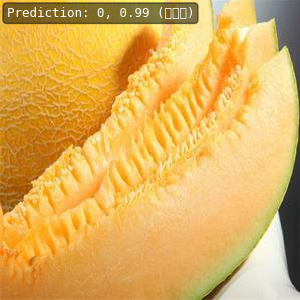